In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import joblib
import numpy as np
import xarray as xr
import seaborn as sns
import sys
from glob import glob 
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
# from matplotlib.gridspec import GridSpec
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors


from sklearn.metrics import r2_score, mean_squared_error
from collections import Counter

from functools import partial



sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import helper

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

sys.path.append('/home/freimax/msc_thesis/scripts/IFS-18/')
import traj_processing_functions
import data_preprocessing_helpers

sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers
import make_plots_traj

---
### Function

In [11]:
from tqdm import tqdm

def get_intensifaction_df(dfbig):
    
    def process_item(i):
        # Calculate mean wind in radius r around cyclone center
        mean_wind_200 = traj_processing_functions.get_avg_geostrophic_wind_era5(df=dfbig, cyc_id=i, radius=200, show_plot=False)
        # mean_wind_500 = traj_processing_functions.get_avg_geostrophic_wind_era5(df=dfbig, cyc_id=i, radius=500, show_plot=False)

        ## Calculate total cooling
        df_1cyc = dfbig[(dfbig['id_CYC']==i) & (dfbig['time']==0)]
        date = df_1cyc['date'].unique().item()
        region = df_1cyc['region'].unique().item()
        # basin = df_1cyc['basin'].unique().item()
        Atsubsi_pred_mean  = np.mean(df_1cyc['Atsubsi_pred'])
        Atmeltsi_pred_mean = np.mean(df_1cyc['Atmeltsi_pred'])
        Atevr_pred_mean    = np.mean(df_1cyc['Atevr_pred'])
        return date, i, region, mean_wind_200, Atsubsi_pred_mean, Atmeltsi_pred_mean, Atevr_pred_mean
        # return date, i, region, basin, mean_wind_200, mean_wind_500, Atsubsi_pred_tot, Atmeltsi_pred_tot

    id_array = np.unique(dfbig['id_CYC']).astype(int)

    # Define an empty list to store rows
    rows_df = []

    # Iterate through id_array and process each item
    for i in tqdm(id_array):
        res = process_item(i)
        # date, i, region, basin, mean_wind_200, mean_wind_500, Atsubsi_pred_tot, Atmeltsi_pred_tot = res
        date, i, region, mean_wind_200, Atsubsi_pred_tot, Atmeltsi_pred_tot, Atevr_pred_mean = res
        rows_df.append({
            'date': date,
            'id_CYC': i,
            'region': region,
            # 'basin': basin,
            'mean_wind_200': mean_wind_200,
            # 'mean_wind_500': mean_wind_500,
            'Atsubsi_pred_mean': Atsubsi_pred_tot,
            'Atmeltsi_pred_mean': Atmeltsi_pred_tot,
            'Atevr_pred_mean': Atevr_pred_mean
        })

    df_intensity = pd.DataFrame(rows_df)
    return df_intensity

---
### Calcualte cyc_intensification data fro df_djf

In [3]:
save_path='/net/helium/atmosdyn/freimax/data_msc/ERA5/trajs/climatology'
df_djf = pd.read_pickle(f'{save_path}/df_big_djf.pkl') 

In [9]:
df_djf['id_CYC'].nunique()

3018

In [12]:
df_djf_intens = get_intensifaction_df(df_djf)

100%|██████████| 3018/3018 [37:16<00:00,  1.35it/s]


In [13]:
df_djf_intens.to_pickle(f'{save_path}/df_djf_intens.pkl')

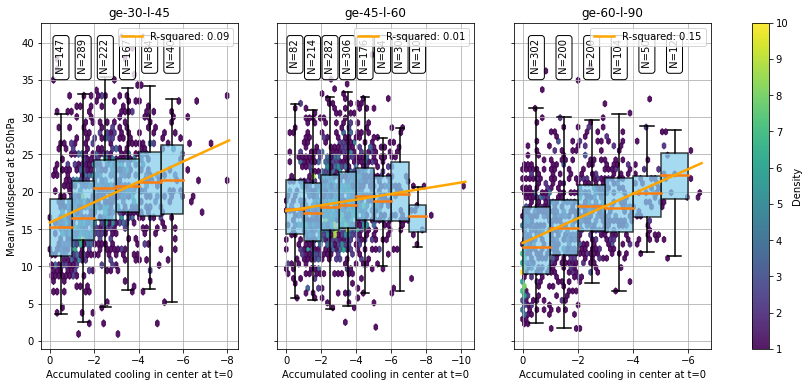

In [20]:
# import matplotlib.pyplot as plt
# from scipy.stats import linregress
# import numpy as np
# sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
# import plot_helpers


# fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# regions = df_djf_intens['region'].unique() # ['ge-30-l-45', 'ge-45-l-60', 'ge-60-l-90']

# for region_idx, region in enumerate(regions):
#     df_filtered = df_djf_intens[df_djf_intens['region'] == region]
#     cooling = df_filtered['Atsubsi_pred_mean'] + df_filtered['Atmeltsi_pred_mean']

#     # Perform linear regression
#     slope, intercept, r_value, _, _ = linregress(cooling, df_filtered['mean_wind_200'])
#     x_fit = np.linspace(min(cooling), max(cooling), 100)
#     y_fit = slope * x_fit + intercept
    
#     ax = axs[region_idx]
#     hb = ax.hexbin(cooling, df_filtered['mean_wind_200'], gridsize=50, cmap='viridis', mincnt=1, alpha=0.9, zorder=1)
#     ax.grid(zorder=0)
#     ax.plot(x_fit, y_fit, color='orange', linestyle='-', linewidth=2.5, label=f'R-squared: {r_value**2:.2f}', zorder=10)
#     ax.set_title(f'{region}')
    
#     ax.legend()
    
#     if region_idx == 0:
#         ax.set_ylabel(f'Mean Windspeed at 850hPa')
#     ax.invert_xaxis()
#     ax.set_xlabel('Accumulated cooling in center at t=0')
    
    
#     plot_helpers.add_boxplots(x=cooling, y=df_filtered['mean_wind_200'], width_boxplot=1, ax=ax, min_points_boxplot=10, count_per_boxplot=True, fontsize_text=10, input_detail_mode=False, )

# # Create a single colorbar
# cb = fig.colorbar(hb, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)
# cb.set_label('Density')



# save_path='/home/freimax/msc_thesis/figures/thesis_msc/chapter_application_era5/'
# plt.savefig(f'{save_path}/cycint_vs_cooling.png', bbox_inches='tight', dpi=250, )
# plt.show()


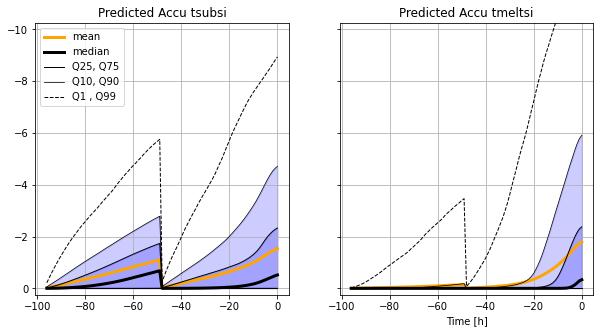

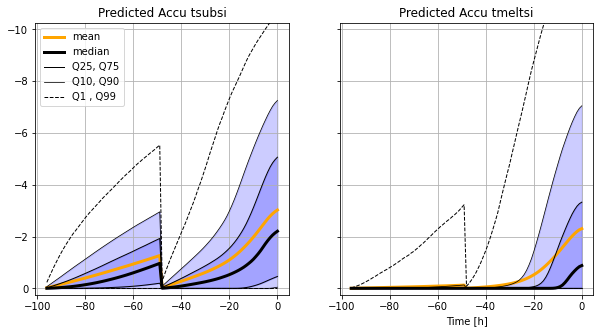

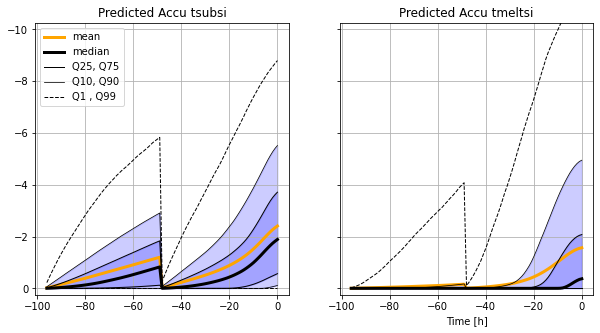

In [79]:
make_plots_traj.plot_accu_cooling_over_time(df_tr=df_big_48[df_big_48['region']=='ge-30-l-45'], df_tr_rf=df_big_48[df_big_48['region']=='ge-30-l-45'],truth_available=False)# date=dates[i], save_path=f'{save_path}/time_evolution_trueANDpred_{dates[i]}.png')
plt.show()
make_plots_traj.plot_accu_cooling_over_time(df_tr=df_big_48[df_big_48['region']=='ge-45-l-60'], df_tr_rf=df_big_48[df_big_48['region']=='ge-45-l-60'],truth_available=False)# date=dates[i], save_path=f'{save_path}/time_evolution_trueANDpred_{dates[i]}.png')
plt.show()
make_plots_traj.plot_accu_cooling_over_time(df_tr=df_big_48[df_big_48['region']=='ge-60-l-90'], df_tr_rf=df_big_48[df_big_48['region']=='ge-60-l-90'],truth_available=False)# date=dates[i], save_path=f'{save_path}/time_evolution_trueANDpred_{dates[i]}.png')
plt.show()

Mean horizontal windspeed at 850hPa:	22.14 m/s


22.143433

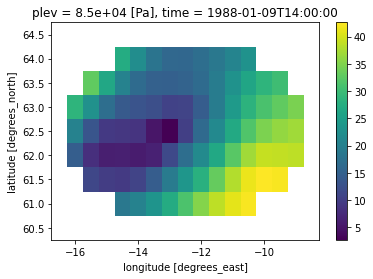

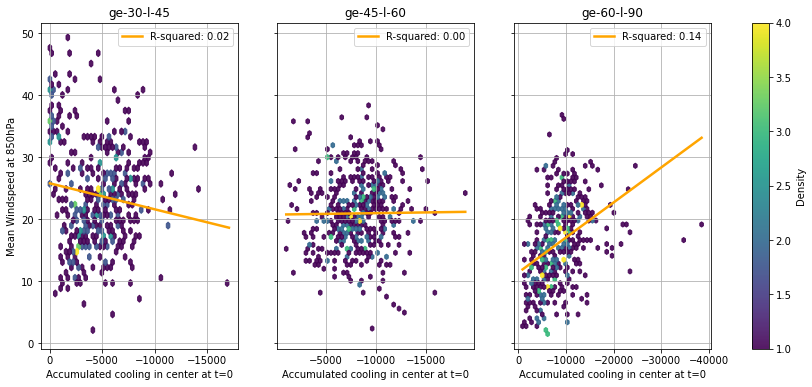

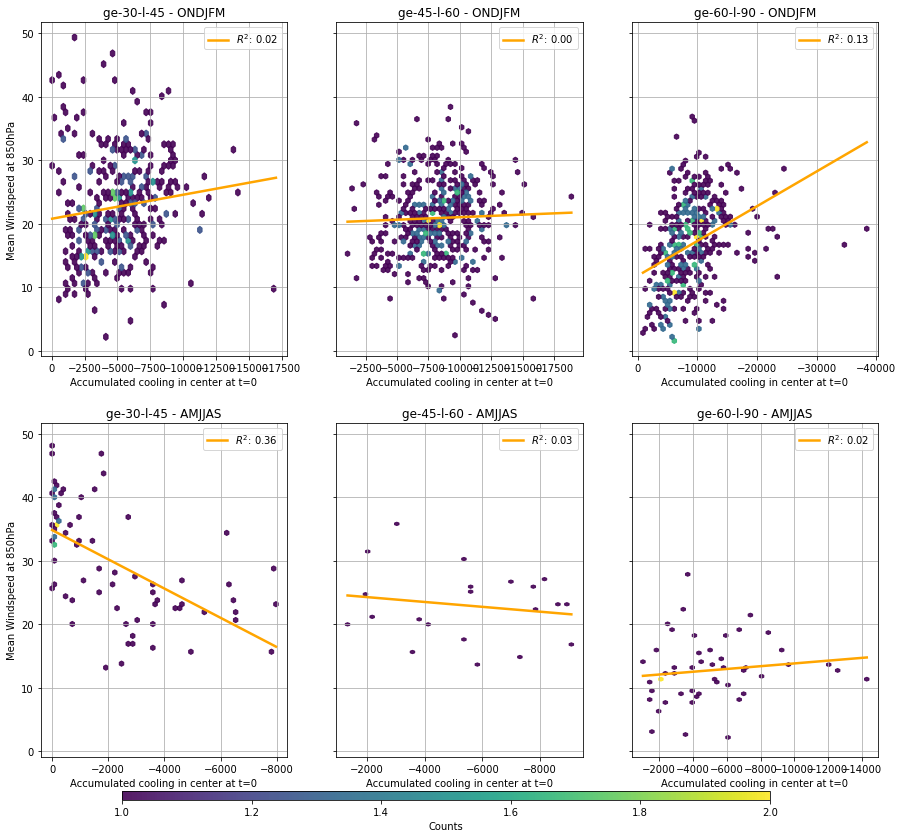

In [85]:

# seasons, col_season = ['DJF', 'MAM', 'JJA', 'SON']  , 'season'
seasons, col_season = ['ONDJFM', 'AMJJAS', ]        , 'ext_season'



fig, axs = plt.subplots(len(seasons), 3, figsize=(15, 6*len(seasons)), sharey=True)
plt.subplots_adjust(bottom=0.1, top=0.95) # Create space for the colorbar at the bottom

regions = df_intensity['region'].unique()



hb = None # Placeholder for the hexbin plot, used later for the colorbar

for season_idx, season in enumerate(seasons):
    for region_idx, region in enumerate(regions):
        df_filtered = df_intensity[(df_intensity['region'] == region) & (df_intensity[col_season] == season)]
        if df_filtered.empty:
            ax = axs[season_idx, region_idx]
            ax.set_title(f'{region} - {season}')            
            continue

        cooling = df_filtered['Atsubsi_pred_tot'] + df_filtered['Atmeltsi_pred_tot']
        slope, intercept, r_value, _, _ = linregress(cooling, df_filtered['mean_wind_200'])
        x_fit = np.linspace(min(cooling), max(cooling), 100)
        y_fit = slope * x_fit + intercept

        ax = axs[season_idx, region_idx]
        hb = ax.hexbin(cooling, df_filtered['mean_wind_200'], gridsize=50, cmap='viridis', mincnt=1, alpha=0.9, zorder=1)
        ax.grid(zorder=0)
        ax.plot(x_fit, y_fit, color='orange', linestyle='-', linewidth=2.5, label=f'$R^2$: {r_value**2:.2f}', zorder=10)
        ax.set_title(f'{region} - {season}')

        ax.legend()
        if region_idx == 0:
            ax.set_ylabel(f'Mean Windspeed at 850hPa')
        ax.invert_xaxis()
        ax.set_xlabel('Accumulated cooling in center at t=0')

# Create colorbar at the bottom
cax = fig.add_axes([0.2, 0.05, 0.6, 0.01]) # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cax, orientation='horizontal')
cb.set_label('Counts')

plt.show()


In [62]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def process_item(i):
    mean_wind_200_test = traj_processing_functions.get_avg_geostrophic_wind_era5(df=df_big, cyc_id=i, radius=200, show_plot=False)
    mean_wind_500_test = traj_processing_functions.get_avg_geostrophic_wind_era5(df=df_big, cyc_id=i, radius=500, show_plot=False)

    ## Calculate total cooling
    df_1cyc = df_big[(df_big['id_CYC']==i) & (df_big['time']==0)]
    Atsubsi_tot_pred  = np.sum(df_1cyc['Atsubsi_pred'])
    Atmeltsi_tot_pred = np.sum(df_1cyc['Atmeltsi_pred'])
    
    return mean_wind_200_test, mean_wind_500_test, Atsubsi_tot_pred + Atmeltsi_tot_pred



mean_wind_200 = []
mean_wind_500 = []
total_cooling_pred = []

# parallelize loop using ProcessPoolExecutor 
with ProcessPoolExecutor(max_workers=60) as executor:
    results = list(tqdm(executor.map(process_item, id_array), total=len(id_array)))

# Unpack results 
for res in results:
    mean_wind_200_test.append(res[0])
    mean_wind_500_test.append(res[1])
    total_cooling_pred_test.append(res[2])

print('DONE')


100%|██████████| 687/687 [00:19<00:00, 34.84it/s]


DONE


In [20]:
all_lons

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

Crossing dateboundary on left edge

Crossing Dateboundary:  True


 359 369 


Date-boundary is crossed!


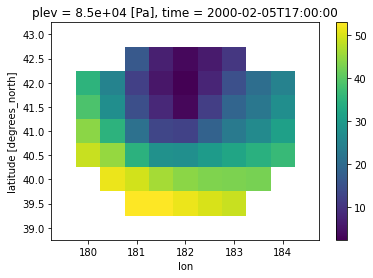

In [21]:
cyc_id = 4
cyc_id = 39

df=df_big_NP
radius=200
show_plot=True
verbose=0

    
df_1cyc = df[df['id_CYC']==cyc_id]
date = df_1cyc['date'].unique()[0]
year  = date[0:4]
num_month = date[4:6]

## Load the ERA5 file
era5_path = f'/net/thermo/atmosdyn/era5/cdf/{year}/{num_month}'
ds_p = xr.open_dataset(f'{era5_path}/Z{date}')
ds_p = ds_p.sel(lat=slice(0,90)).squeeze()

gridpoints_lon = ds_p.lon.shape[0]
gridpoints_lat = ds_p.lat.shape[0]
## Initialise longitudes and latitudes
LAT = np.linspace(0,90,gridpoints_lat)
LON = np.linspace(-180,179.5,gridpoints_lon)

## Retrieve the center longitutde and latitude of the cyclone as the median of the points
center_lon = np.mean(np.unique(df_1cyc[df_1cyc['time']==0]['lon']))
center_lat = np.mean(np.unique(df_1cyc[df_1cyc['time']==0]['lat']))


## Cal function that return concatenated array of all longitudes and another array with the correspondign latitudes
CLONIDS, CLATIDS = helper.ERA5_radial_ids_correct(radius,center_lat)

center_lon_rounded = np.round(center_lon * 2) / 2
center_lat_rounded = np.round(center_lat * 2) / 2

addlon = CLONIDS + np.where(LON==center_lon_rounded)[0][0]

## Check if any point (integer of grid) touches the dateboundary
crossing_dateboundary = False 
if np.any(addlon == (gridpoints_lon-1)):    # Check if any of the mask points has lon-index value of 719 (correpsonds to left-most point)
    clon = addlon - (gridpoints_lon)/2      # Shift grid by 180 degrees to avoid date-boundary
    crossing_dateboundary = True            # Set flag, since it will be needed later

elif np.any(addlon < 1):                    # Check if left-most point of mask corses dateboundary
    clon = addlon + (gridpoints_lon)/2
    crossing_dateboundary = True
    print('Crossing dateboundary on left edge')

else:
    clon = addlon
clat = CLATIDS.astype(int) + np.where(LAT==center_lat_rounded)[0][0]

print('\nCrossing Dateboundary: ',crossing_dateboundary)

# Create a rectangular box around cyclone-center-engulfing cuircle with specified radius
all_lons = np.arange(clon.min()-1, clon.max()+2, 1)
all_lats = np.arange(clat.min()-1, clat.max()+2, 1)
lon_grid, lat_grid = np.meshgrid(all_lons, all_lats)

# Initialize mask that represents circle around cyclone center with specified radius 
mask = np.full(lon_grid.shape, np.nan)
# Check whether each pair is in the list that contains all coordiantes of circle around cyclone center
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        if np.any((clon == lon_grid[i, j]) & (clat == lat_grid[i, j])):
            mask[i, j] = 1  # If point is inside the circle

# If date_boundary crossing flag is set, concatenate the era5 fields around the date-boundary
if crossing_dateboundary:
    # Concatenate the data across the date boundary
    ds_region = xr.concat([ds_p.sel(lon=slice(0, 179.5)), ds_p.sel(lon=slice(-180, -0.5))], dim='lon')
    # ds_region['lon'] = np.mod(ds_region['lon'], 360)  # wrap longitudes to 0-360 degrees
    all_lons = all_lons.astype(int)
    all_lats = all_lats.astype(int)
    print('\n\n',all_lons.min(),all_lons.max(),'\n\n')
    ds_p_cyc = ds_region.isel(lon=slice(all_lons.min(),all_lons.max()+1), lat=slice(all_lats.min(), all_lats.max()+1))
    print('Date-boundary is crossed!')
else:
    ds_p_cyc = ds_p.isel(lon=slice(all_lons.min(),all_lons.max()+1), lat=slice(all_lats.min(), all_lats.max()+1))


## Interpolate pressure field onto specified pressure-level 
da_u_850 = ds_p_cyc['U'].sel(plev=85000)
da_v_850 = ds_p_cyc['V'].sel(plev=85000)
da_gs_850 = np.sqrt(da_u_850**2 + da_v_850**2)

## Only keep circular mask
da_gs_850 = da_gs_850.where(mask == 1)

## Calculate mean wind on that pressure level
mean_wind = np.nanmean(da_gs_850.values)
if verbose > 0:
    print(f'Mean horizontal windspeed at 850hPa:\t{mean_wind:.2f} m/s')

## Create a oplot of wind at 850hPa
if show_plot:
    if crossing_dateboundary:
        # Adjust longitude
        longitude = ds_p_cyc.lon.values
        longitude = (longitude + 360) % 360
        da_gs_850.coords['lon'] = longitude
        # Sort the DataArray
        da_gs_850 = da_gs_850.sortby('lon')
        da_gs_850.plot();
    else:
        da_gs_850.plot();



In [52]:
np.round(center_lat,1)

39.2